# Cats vs Dogs - The Final Showdown

[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) is a `Kaggle`'s competition where using the dataset you have to create `classifier` that can classify images as `dog` or `cat`.

In [1]:
import gc
import os
from os import listdir
from os.path import isfile, join

import json
import zipfile
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 🏂 Getting the dataset

In [2]:
# Extracting all of the zip files

# Training dataset
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as z:
     z.extractall('../data')
    
# Testing dataset
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as z:
    z.extractall('../data')

In [3]:
os.listdir('../data')

['test', 'train']

`create_df` will return a shuffled `pd.DataFrame` which will have two columns namely `label` and `img_path`(which will have individual img path).

Also `Cat = 0, Dog = 1` (labels info).

In [4]:
# Cat = 0, Dog = 1
def create_df():
    path = '../data/train'
    dataset = []
    for f in listdir(path):
        if isfile(join(path, f)):
            if 'cat' in f:
                dataset.append({'label': 0, 'img_path': join(path, f)})
            elif 'dog' in f:
                dataset.append({'label': 1, 'img_path': join(path, f)})

    df = pd.DataFrame(dataset)

    # shuffling the dataframe and resetting the index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [5]:
# Getting the dataset
df = create_df()
df.sample(5)

label                    img_path
28         1  ../data/train/dog.9362.jpg
16251      1  ../data/train/dog.7098.jpg
5761       1  ../data/train/dog.2349.jpg
3908       1  ../data/train/dog.7573.jpg
19065      1  ../data/train/dog.5186.jpg

In [6]:
# converting labels dtype to str
# to use class_mode='binary' in ImageDataGenerators
df.label = df.label.astype('str')
df.sample(5)

label                     img_path
14975     1   ../data/train/dog.1922.jpg
7581      1    ../data/train/dog.102.jpg
4639      0   ../data/train/cat.1886.jpg
21261     1  ../data/train/dog.11331.jpg
11682     1   ../data/train/dog.2295.jpg

## 🤸‍♂️ Data preparation

In [7]:
print(f'Dataset size: {len(df)}')

Dataset size: 25000


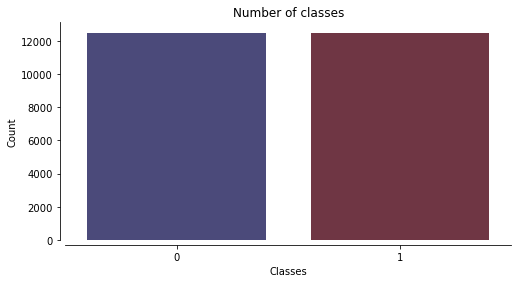

In [8]:
# See if dataset is balanced or not

plt.figure(figsize=(8, 4))
plt.title('Number of classes')
g = sns.countplot(df.label, palette='icefire')
g.set(xlabel='Classes', ylabel='Count')
sns.despine(offset=5)
plt.show()

![](https://media.giphy.com/media/PlaOtXOHSpKtBwUw5X/giphy.gif)

In [9]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(df.img_path, df.label, test_size=0.1, random_state=0)

# Splitting the remaining training set into training and test sets
# This set is different from the set ==> /kaggle/working/dogs-vs-cats/test/
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

In [10]:
# Converting the above pandas series to dataframe
train_df = pd.DataFrame({ 'label': y_train, 'img_path': x_train }).reset_index(drop=True)
val_df   = pd.DataFrame({ 'label': y_val, 'img_path': x_val }).reset_index(drop=True)
test_df  = pd.DataFrame({ 'label': y_test, 'img_path': x_test }).reset_index(drop=True)

# Printing the sets size
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Testing set size: {len(test_df)}')

Training set size: 20250
Validation set size: 2500
Testing set size: 2250


In [11]:
train_df.sample(5)

label                    img_path
8111      0  ../data/train/cat.8561.jpg
15849     0  ../data/train/cat.9342.jpg
6123      1   ../data/train/dog.952.jpg
16911     0   ../data/train/cat.977.jpg
6301      0  ../data/train/cat.1543.jpg

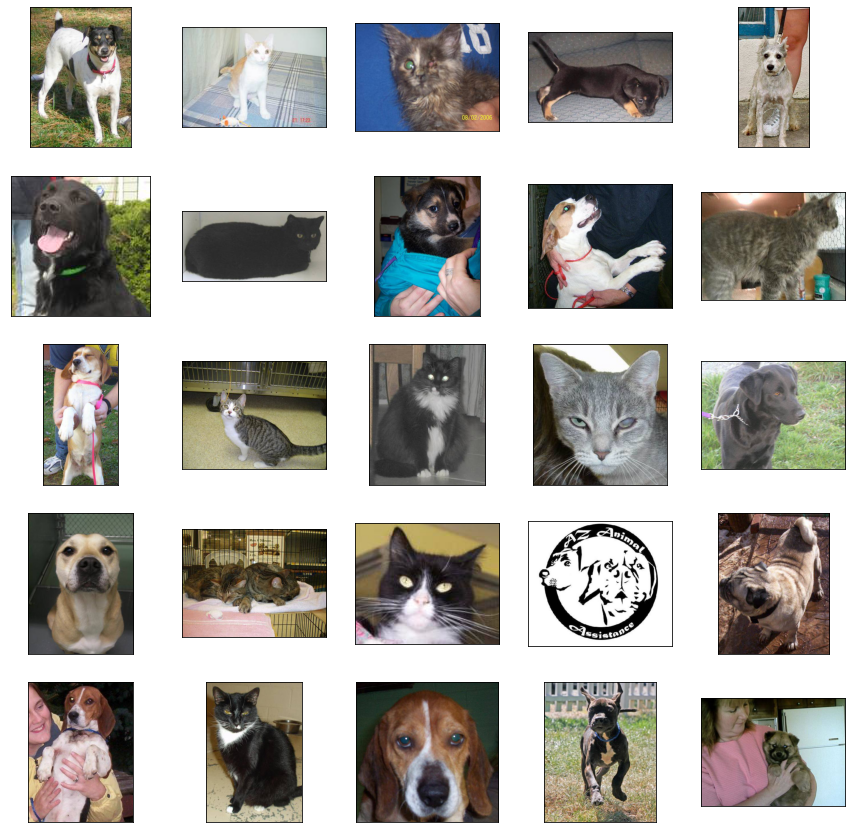

In [12]:
# Looking at first 25 training examples

plt.figure(figsize=(15, 15))
for i, _img_path in enumerate(x_train[:25]):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title('')
    img = load_img(_img_path)
    plt.imshow(img)

In [13]:
# Global variables

IMG_HEIGHT = 150
IMG_WIDTH  = 150
CHANNELS   = 3

BATCH_SIZE = 16

`process_images` function is used here for processing test data `(./dogs-vs-cats/test/test -- directory)`.

In [14]:
def process_images(list_of_images):
    x = []  # holds images
    y = []  # hold labels
    
    for image in list_of_images:
        x.append(
            cv2.resize(
                cv2.imread(image, cv2.IMREAD_COLOR),
                (IMG_HEIGHT, IMG_WIDTH),
                interpolation=cv2.INTER_CUBIC
            )
        )
        
        if 'dog' in image:
            y.append(1)
        if 'cat' in image:
            y.append(0)
    
    return x, y

### 🤼 Data augmentation

![](https://media.giphy.com/media/10TB6QfNrahdhS/giphy.gif)

**Instantiating ImageDataGenerators**

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=10, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,
    zoom_range = 0.1,
)

val_datagen = ImageDataGenerator(rescale=1./255)

`flow_from_dataframe` method of `ImageDataGenerator`s will take the path of the images and will `load`, `normalize` and `augment` them on fly while training.

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='img_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='img_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    # shuffle=True,
    class_mode='binary'
)

Found 20250 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


## 🏄‍♂️ Modelling

Using the `VGG16` CNN architecture and training it for our classifier. 

In [17]:
def get_VGG16_model(input_shape):
    model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(model.output)
    Dropout(0.5)(x)
    Dense(4096, activation='relu')(x)
    Dense(4096, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(model.input, output)
    
    return model


def get_InceptionV3_model(input_shape):
    model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(model.output)
    Dropout(0.5)(x)
    Dense(4096, activation='relu')(x)
    Dense(4096, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(model.input, output)
    
    return model


model = get_InceptionV3_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
model.summary()
print()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_____________________________

In [18]:
# Building the CustomCallback for getting more info on model's performance
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        precision = logs['precision']
        recall = logs['recall']
        f1_score = (2 * (precision * recall)) / (precision + recall)
        
        loss = logs['loss']
        accuracy = logs['accuracy']
        auc_roc = logs['auc_roc']
        
        # Validation
        val_loss = logs['val_loss']
        val_accuracy = logs['val_accuracy']
        val_auc_roc = logs['val_auc_roc']
        val_precision = logs['val_precision']
        val_recall = logs['val_recall']
        val_f1_score = (2 * (val_precision * val_recall)) / (val_precision + val_recall)
        
        info = {
            'loss': round(loss, 5),
            'accuracy': round(accuracy, 4),
            'auc_roc': round(auc_roc, 4),
            'precision': round(precision, 4),
            'recall': round(recall, 4),
            'f1_score': round(f1_score, 4),
            'val_loss': round(val_loss, 5),
            'val_accuracy': round(val_accuracy, 4),
            'val_auc_roc': round(val_auc_roc, 4),
            'val_precision': round(val_precision, 4),
            'val_recall': round(val_recall, 4),
            'val_f1_score': round(val_f1_score, 4),
        }
        
        print(f'\n{json.dumps(info, indent=2)}')
        print()

        

callbacks = [
    ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2, min_lr=0.000001, verbose=1),
    CustomCallback()
]

In [19]:
num_epoch = 1
optimizer = Adam(learning_rate=0.0001)
loss = 'binary_crossentropy'

metrics = [
    'accuracy', 
    AUC(curve='ROC', name='auc_roc'), 
    Precision(name='precision'), 
    Recall(name='recall')
]

In [20]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

Turn on the `GPU` accelerator to speed up `learning`.

In [21]:
history = model.fit(
    train_generator, 
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    batch_size=BATCH_SIZE, 
    validation_data=val_generator, 
    epochs=num_epoch,
    callbacks=callbacks
)

1265/1265 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9134 - auc_roc: 0.9730 - precision: 0.9210 - recall: 0.9058
{
  "loss": 0.21285,
  "accuracy": 0.9134,
  "auc_roc": 0.973,
  "precision": 0.921,
  "recall": 0.9058,
  "f1_score": 0.9134,
  "val_loss": 0.08775,
  "val_accuracy": 0.9636,
  "val_auc_roc": 0.9952,
  "val_precision": 0.9746,
  "val_recall": 0.9496,
  "val_f1_score": 0.9619
}

1265/1265 [==============================] - 186s 147ms/step - loss: 0.2129 - accuracy: 0.9134 - auc_roc: 0.9730 - precision: 0.9210 - recall: 0.9058 - val_loss: 0.0877 - val_accuracy: 0.9636 - val_auc_roc: 0.9952 - val_precision: 0.9746 - val_recall: 0.9496 - lr: 1.0000e-04


**Plotting model's performance**

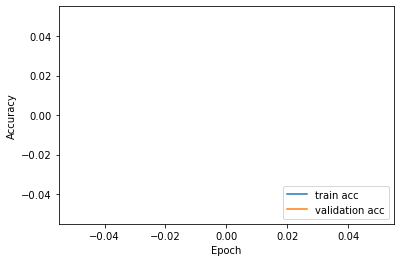

In [22]:
# Accuracy

plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'][1:], label='validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

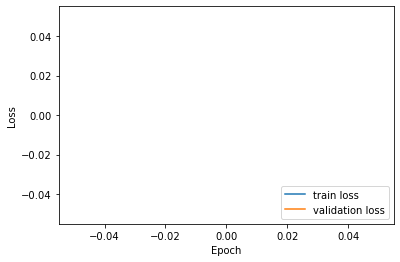

In [23]:
# Loss

plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'][1:], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

### 🏇 Visualizing CNN

To know more read the following posts: [post_1](https://www.analyticsvidhya.com/blog/2018/03/essentials-of-deep-learning-visualizing-convolutional-neural-networks/), [post_2](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/) and [post_3](https://www.kaggle.com/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn).

To `visualize how CNN and Max pooling works` go through the following [kernel](https://www.kaggle.com/akashsdas/how-does-convolutions-work).

**Visualize filters**

Plotting the `0th` filter of the `1st conv layer`.

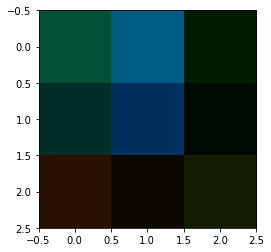

In [24]:
top_layer = model.layers[1]
plt.imshow(top_layer.get_weights()[0][:, :, :, 0].squeeze())

In [25]:
def plot_filters_for_conv_layer(model, layer_index, num_columns=5, cmap='binary', how_many='all'):
    layer = model.layers[layer_index]
    filter_weights = layer.get_weights()[0]
    
    num_filters = layer.filters if how_many == 'all' else how_many
    num_rows = (num_filters // num_columns) + (num_filters % num_columns)
    # example:
    # num_rows = (96 // 5) + (96 % 5) == 20 (to plot all the filters)
    
    f, axs = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    row_count = 0  # to plot num_columns figs in an individual row
    
    if not isinstance(axs, np.ndarray):
        # When num_cloumns == how_many
        axs = np.array(axs)  # to make axs iterable
        # list can also be inplace np.array but since plt.subplots axs output is of type np.ndarray I kept 
        
    for idx, row_ax in enumerate(axs):
        # plotting filters in a row
        for i, ax in enumerate(row_ax):
            if row_count + i >= num_filters:
                break
                
            if len(filter_weights.shape) == 4:
                if filter_weights.shape[2] == 1:
                    # For plotting filters whose weight shape is == (kernel_size_x, kernel_size_y, 1, #filters)
                    # example: (11, 11, 1, 96)
                    ax.imshow(filter_weights[:, :, :, row_count + i].squeeze(), cmap=cmap)
                else:
                    # For plotting filters whose weight shape is == (kernel_size_x, kernel_size_y, num > 1, #filters)
                    # example: (5, 5, 96, 256)
                    # because if ax.imshow(filter_weights[:, :, :, row_count + i].squeeze(), cmap=cmap)
                    # is used then we'll have array of (5, 5, 96) which is invalid image data for plotting 2D image
                    # (in above case where `filter_weights.shape[2] == 1` there we'll end up with (11, 11, 1) which
                    # after applying the `squeeze` function will be (11, 11) which is valid image data) so in 
                    # that case we'll just plot (5, 5) plot in the first 3D array i.e. (5, 5, 0, row_count + i) 
                    # => this is what we'll plot. To plot (5, 5, row_count + i, 0) just change indexing from
                    # [:, :, 0, row_count + i] to [:, :, row_count + i, 0]
                    ax.imshow(filter_weights[:, :, 0, row_count + i].squeeze(), cmap=cmap)
                    
                # For generalization this can be used, but to understand why 0 need to be used,
                # using the above way
                # ax.imshow(filter_weights[:, :, 0, row_count + i].squeeze(), cmap=cmap)
            else:
                break
                            
        # increasing row_count by num_columns
        row_count += num_columns 

In [26]:
conv_layers_idxs = [idx for idx in range(len(model.layers)) if 'conv' in model.layers[idx].name]
print(len(conv_layers_idxs))

' | '.join([str(idx) for idx in conv_layers_idxs])

94


'1 | 4 | 7 | 11 | 14 | 18 | 21 | 22 | 28 | 29 | 30 | 31 | 41 | 44 | 45 | 51 | 52 | 53 | 54 | 64 | 67 | 68 | 74 | 75 | 76 | 77 | 87 | 90 | 93 | 94 | 101 | 104 | 107 | 108 | 113 | 114 | 120 | 121 | 122 | 123 | 133 | 136 | 139 | 140 | 145 | 146 | 152 | 153 | 154 | 155 | 165 | 168 | 171 | 172 | 177 | 178 | 184 | 185 | 186 | 187 | 197 | 200 | 203 | 204 | 209 | 210 | 216 | 217 | 218 | 219 | 229 | 232 | 235 | 236 | 241 | 242 | 249 | 252 | 253 | 258 | 259 | 260 | 261 | 263 | 268 | 280 | 283 | 284 | 289 | 290 | 291 | 292 | 294 | 299'

Using `cmap` as `sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)` instead of `binary`, just to make the plot look `beautiful as you`. Also there are `96` filters in the `1st conv` layer so only plotting the first `20` filters.

Visualizing `only first 20` filters in the `1nd conv layer`. Here `sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)` is used as `cmap`.

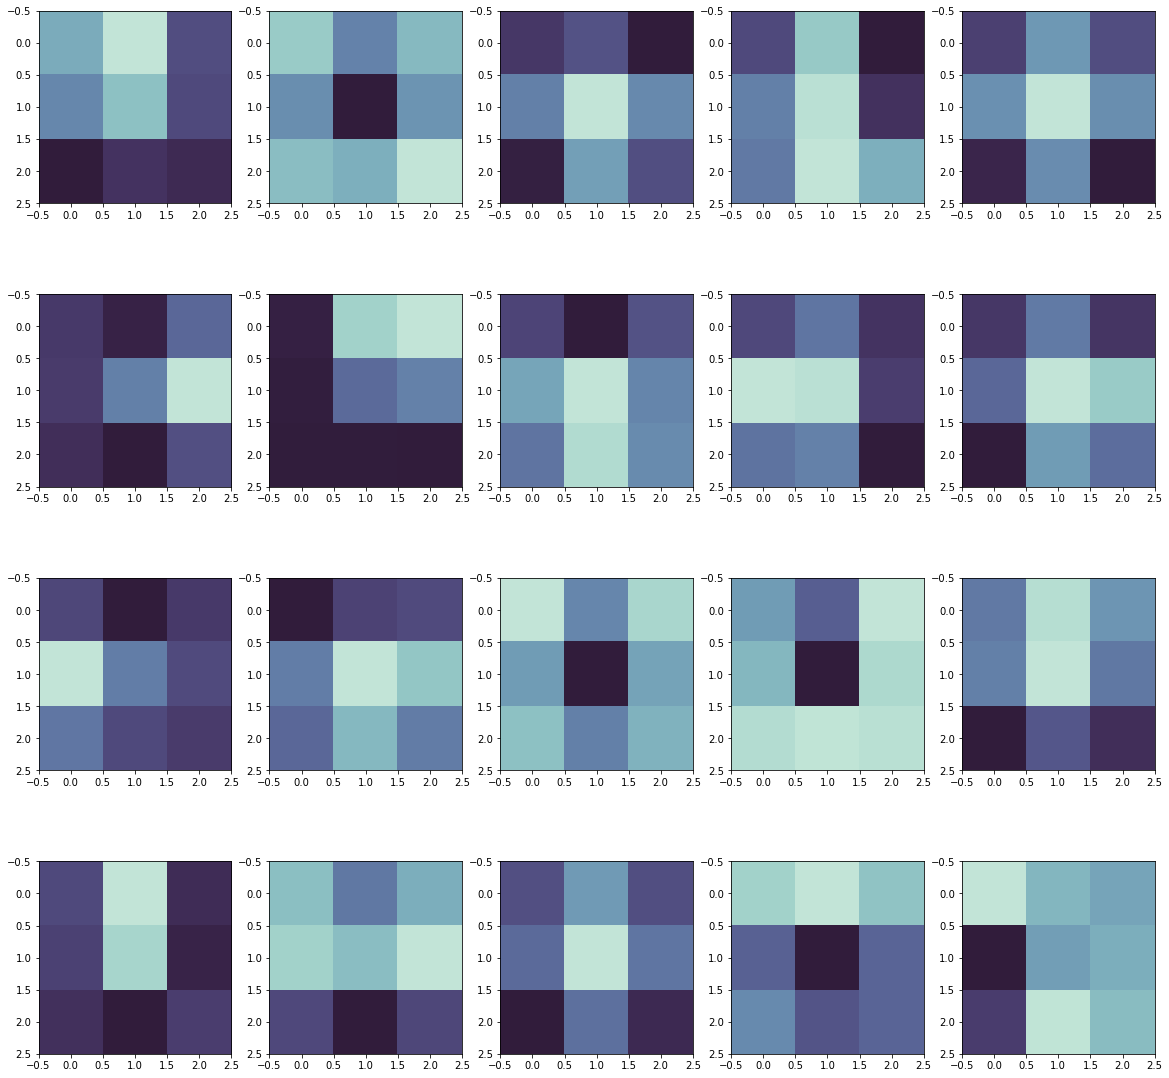

In [27]:
plot_filters_for_conv_layer(
    model, 
    conv_layers_idxs[0], 
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), 
    how_many=20
)  

Visualizing `only first 10` filters in the `2nd conv layer`. Here `binary` is used as `cmap`.

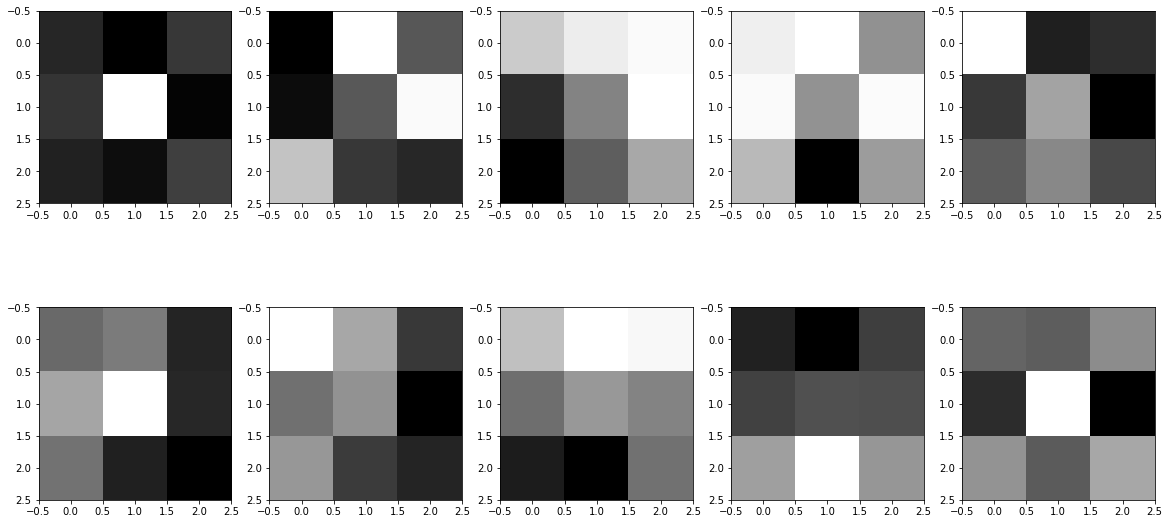

In [28]:
plot_filters_for_conv_layer(
    model, 
    conv_layers_idxs[1], 
    num_columns=5,
    how_many=10
)  

**Visualizing feature maps**

The `feature maps` of a `CNN` capture the result of `applying the filters` to an input image i.e at each layer, the feature map is the output of that layer. The reason for visualising a feature map for a specific input image is to try to gain some understanding of what features our CNN detects.

In [29]:
def plot_feature_maps_for_single_conv_layer(model, layer_id, input_img, num_columns=10, cmap='binary'):
    ref_model = Model(inputs=model.inputs, outputs=model.layers[layer_id].output)
    feature_map = ref_model.predict(input_img)
    
    num_filters = feature_map[0].shape[2]
    num_rows = (num_filters // num_columns) + (num_filters % num_columns)

    fig = plt.figure(figsize=(16, 2 * num_rows))
    ix = 1
    for _ in range(num_rows):
        for _ in range(num_columns):
            if ix == num_filters:
                break
        
            # specify subplot and turn of axis
            ax = plt.subplot(num_rows, num_columns, ix)
            ax.set_xticks([])
            ax.set_yticks([])
        
            # plot filter channel in grayscale
            plt.imshow(feature_map[0, :, :, ix-1], cmap=cmap)
            ix += 1
            
    # show the figure
    plt.show()

Let's visualize `feature maps` for `1st` image in `x_train`.

In [30]:
visualize_feature_maps_for = 0

In [31]:
# Doing as `x_train` pd.Series index are not uniform, so resetting the index
img_path = x_train.reset_index(drop=True)[visualize_feature_maps_for]

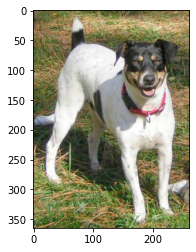

In [32]:
plt.imshow(load_img(img_path))

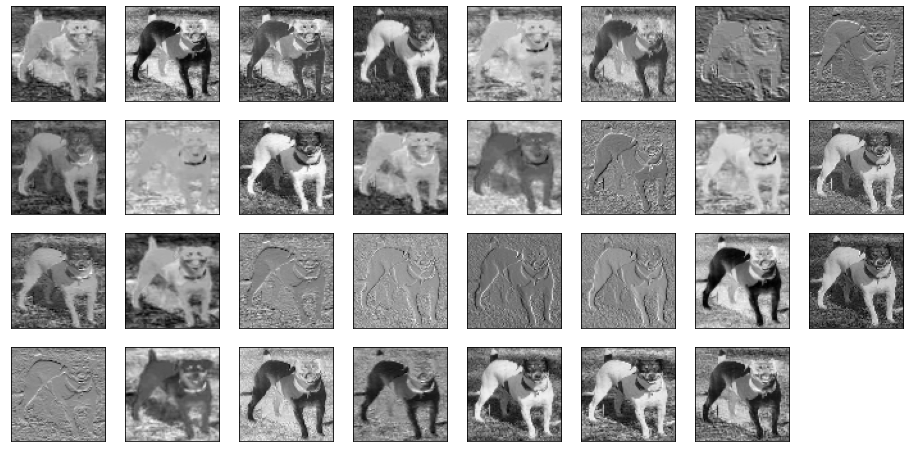

In [33]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[0], 
    process_images([img_path])[0][0][np.newaxis, ...], 
    num_columns=8,
)

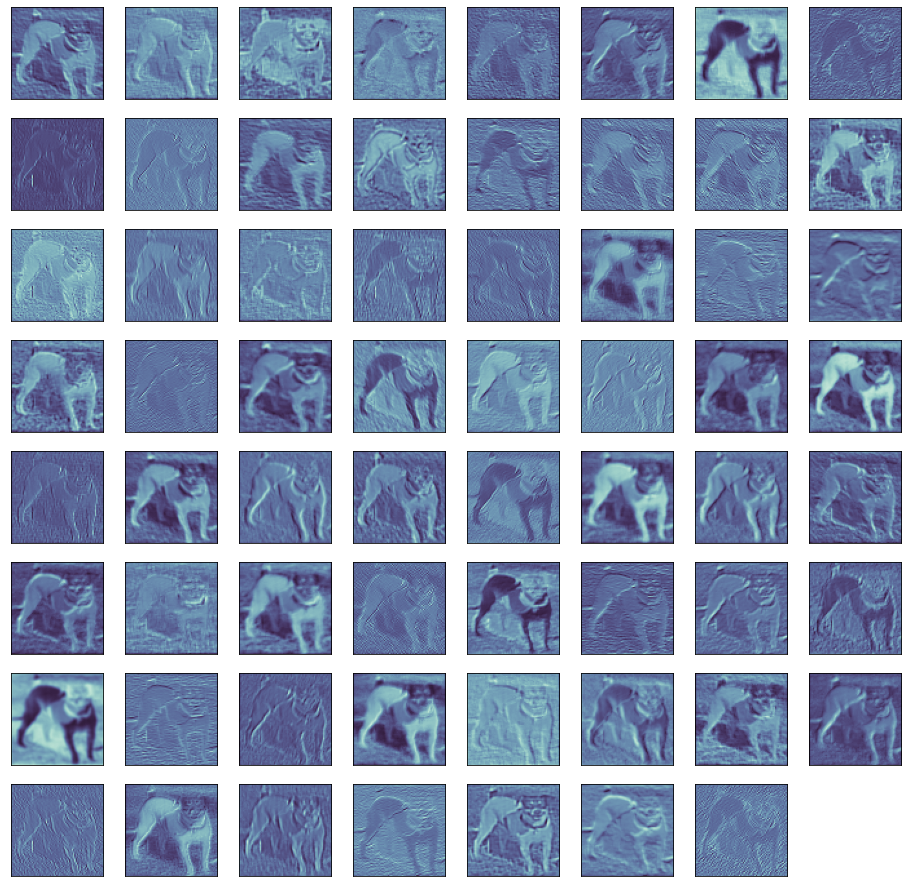

In [34]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[2], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
    num_columns=8,
)

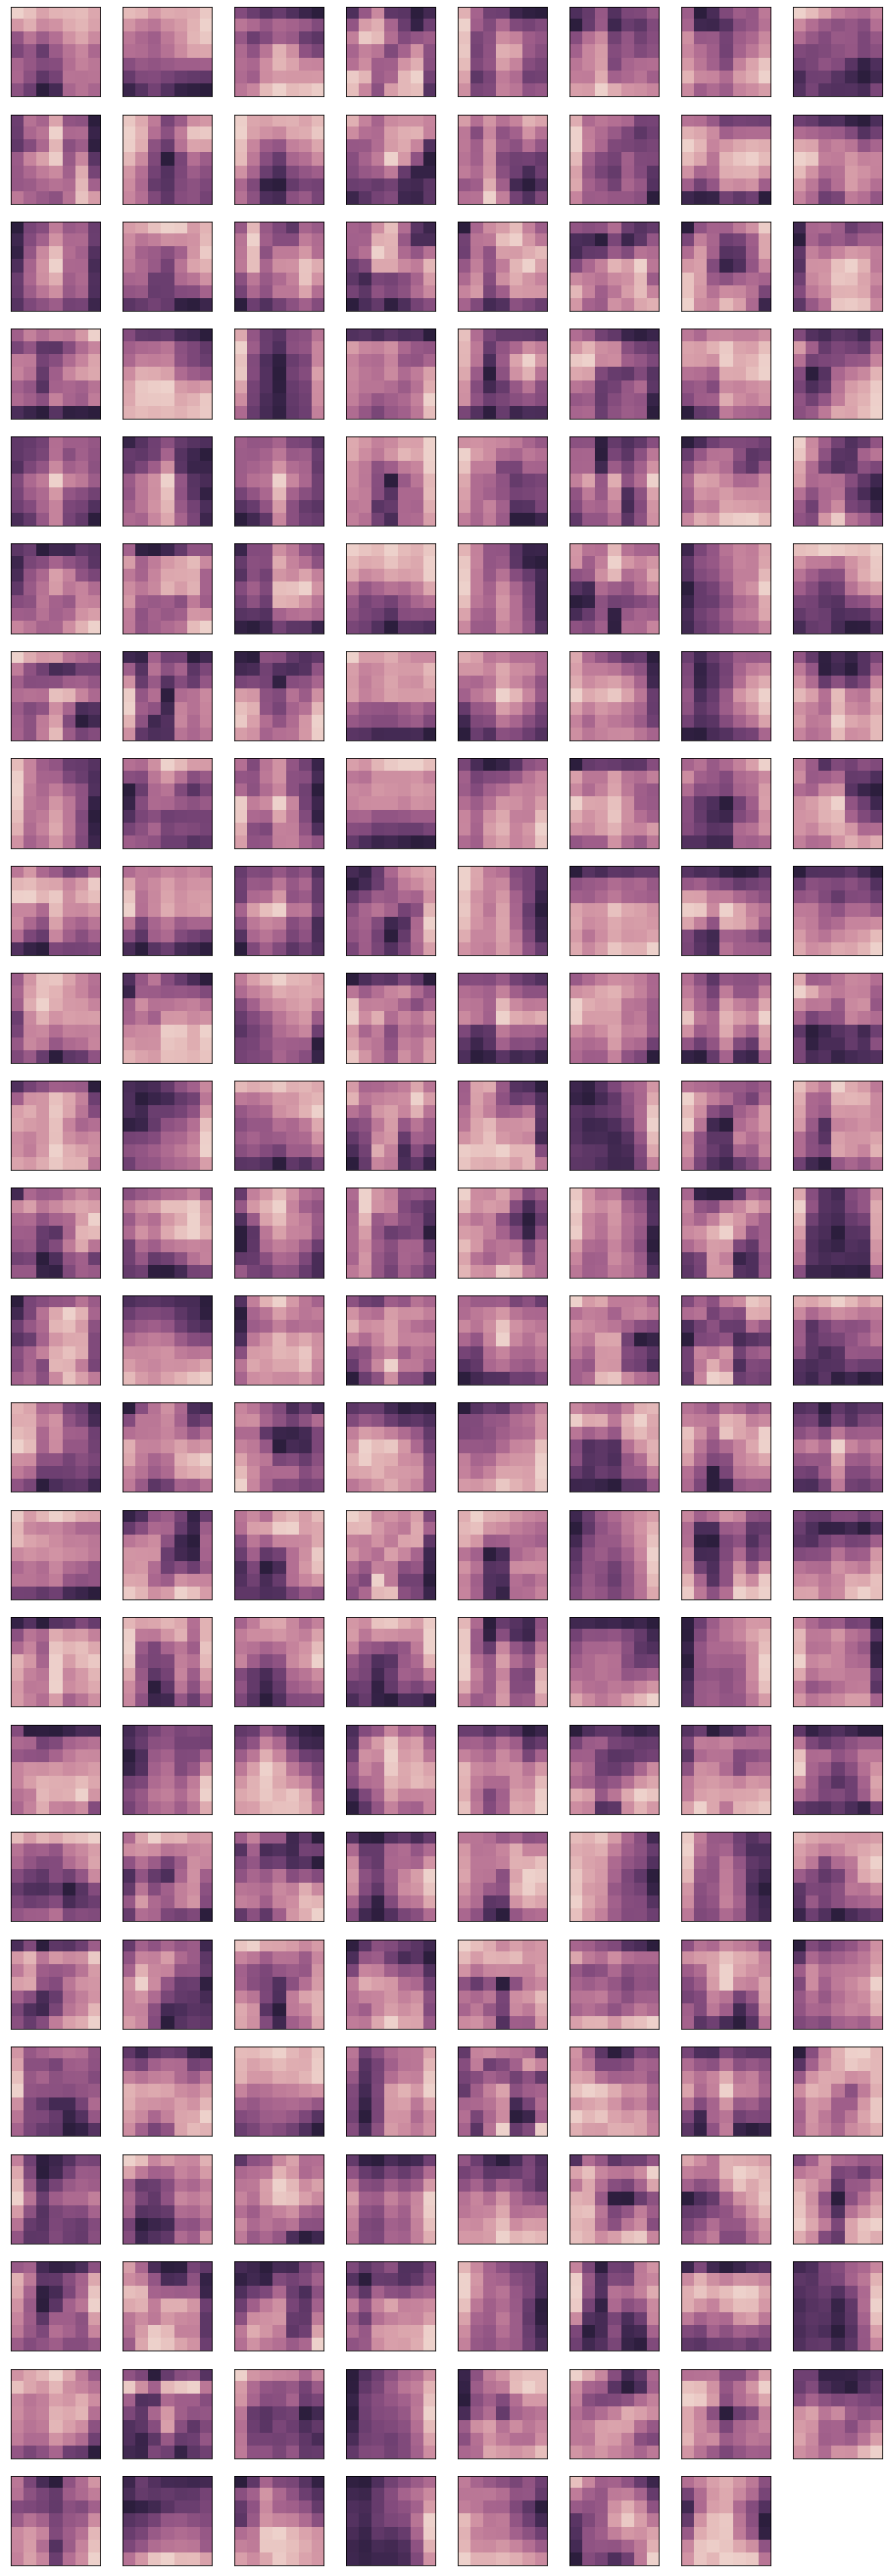

In [35]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[len(conv_layers_idxs) // 2], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(as_cmap=True),
    num_columns=8,
)

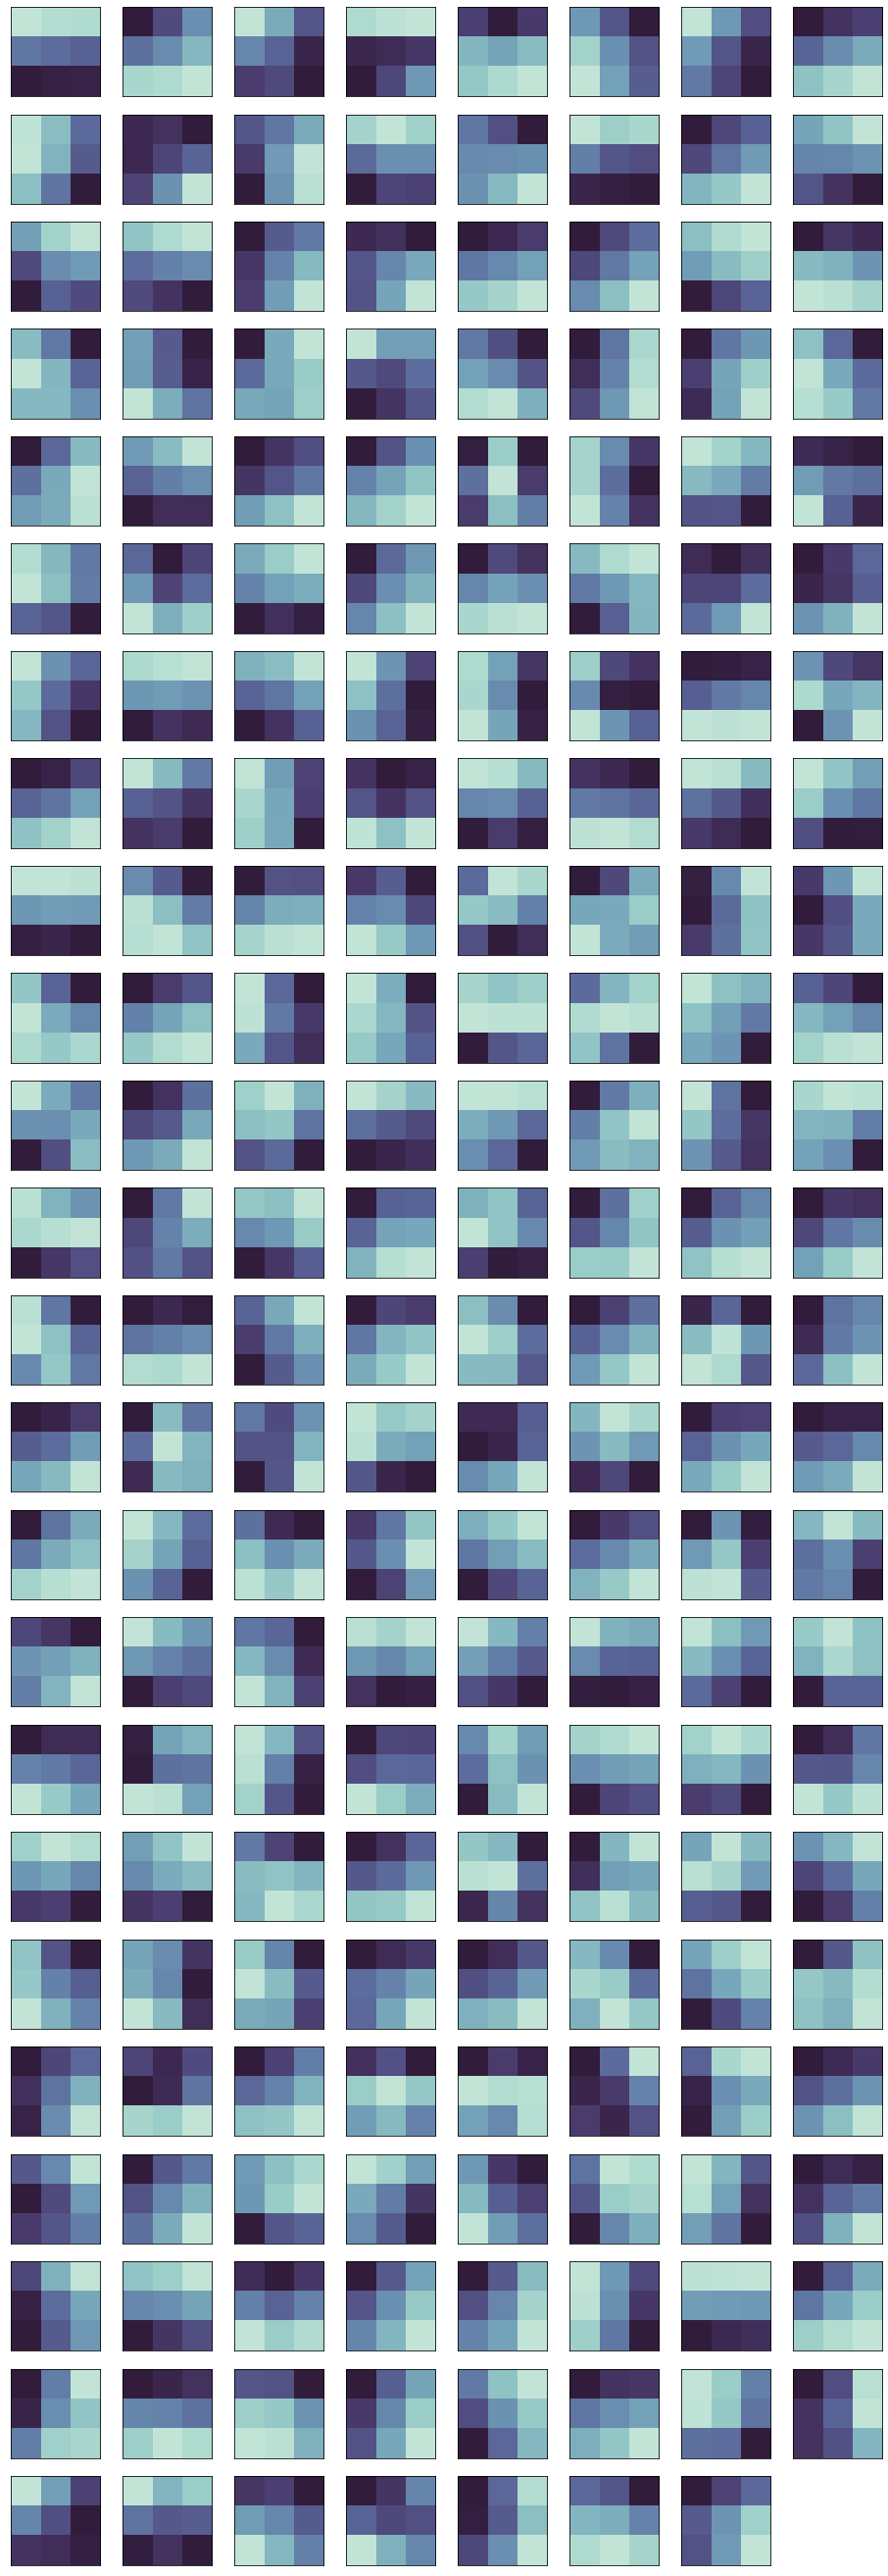

In [36]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[-1], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
    num_columns=8,
)

Let's visualize `feature maps` for `2nd` image in `x_train`.

In [37]:
visualize_feature_maps_for = 1

# Doing as `x_train` pd.Series index are not uniform, so resetting the index
img_path = x_train.reset_index(drop=True)[visualize_feature_maps_for]

plt.imshow(load_img(img_path))

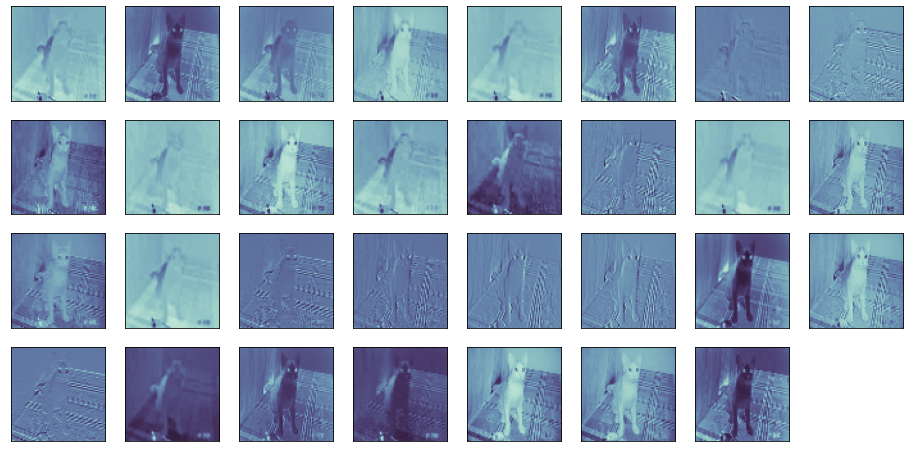

In [38]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[0], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
    num_columns=8,
)

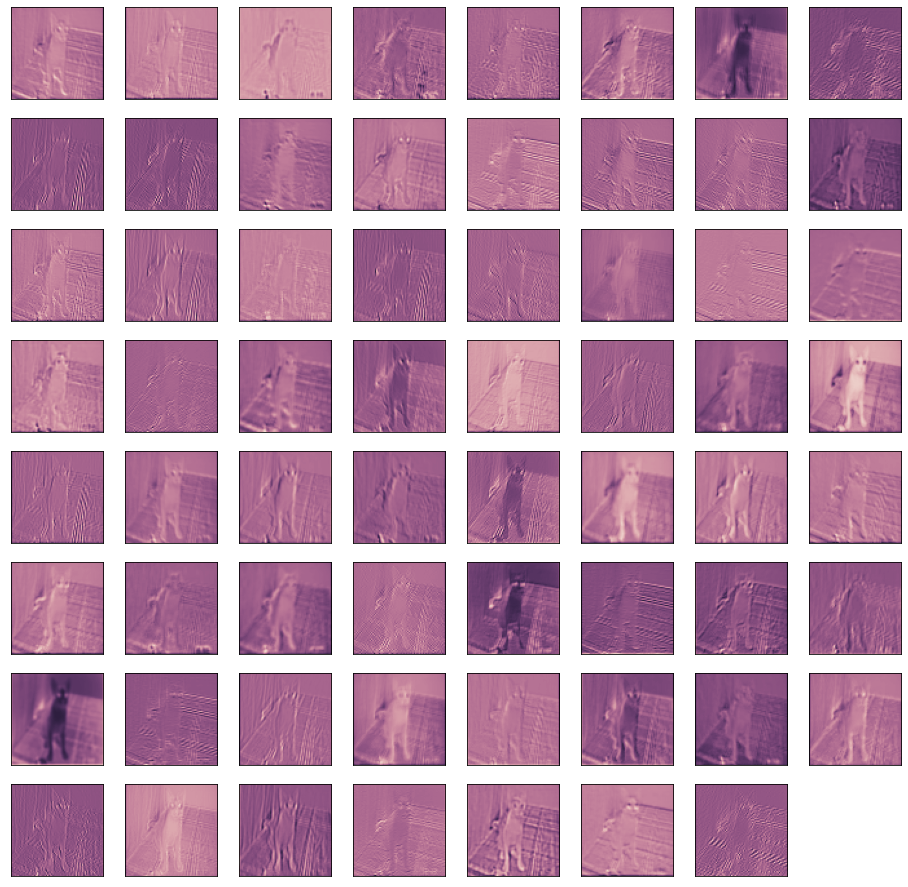

In [39]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[2], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(as_cmap=True),
    num_columns=8,
)

In [40]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[len(conv_layers_idxs) // 2], 
    process_images([img_path])[0][0][np.newaxis, ...],
    num_columns=8,
)

In [41]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[-1], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(as_cmap=True),
    num_columns=8,
)

## 🎯 Evaluation

In [42]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    plt.figure(figsize=(4, 4))
    
    plt.imshow(cm, interpolation='nearest', cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Creating `ImageDataGenerator` for `test_df` which created by splitting the `training dataset`.

In [43]:
# Cat = 0, Dog = 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='img_path',
    y_col='label',    
    batch_size=BATCH_SIZE, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

Found 2250 validated image filenames belonging to 2 classes.


In [44]:
# Evaluating labelled test data
test_results = model.evaluate(train_generator, steps=x_test.shape[0] // BATCH_SIZE)

print()

print(f'Test Loss: {test_results[0]}')
print(f'Test Accuracy: {test_results[1]}')
print(f'Test ACU: {test_results[2]}')
print(f'Test Precision: {test_results[3]}')
print(f'Test Recall: {test_results[4]}')

f1_score_result = 2 * (test_results[3] * test_results[4]) / (test_results[3] + test_results[4])
print(f'Test F1 Score: {f1_score_result}')

140/140 [==============================] - 16s 117ms/step - loss: 0.0899 - accuracy: 0.9656 - auc_roc: 0.9959 - precision: 0.9839 - recall: 0.9490

Test Loss: 0.08986791223287582
Test Accuracy: 0.965624988079071
Test ACU: 0.9959129691123962
Test Precision: 0.9838564991950989
Test Recall: 0.9489619135856628
Test F1 Score: 0.9660942176421357


Again creating `ImageDataGenerator` for `test_df` (which created by splitting the `training dataset`) but without `y_col` and `target_size`.

Doing things in this way rather than 

```python
# Cat = 0, Dog = 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='img_path',
    y_col='label',    
    batch_size=BATCH_SIZE, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

predictions = model.predict(test_generator, verbose=1)
predictions = predictions.flatten()

results = []
for i in predictions:
    if i >= 0.5:
        results.append(1)
    else:
        results.append(0)

plt.figure(figsize=(15, 15))
for i, _img_path in enumerate(test_imgs[:25]):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    if results[i] == 0:
        plt.xlabel(f'Prediction: Cat')
    else:
        plt.xlabel(f'Prediction: Dog')
    img = load_img(_img_path)
    plt.imshow(img)
```

Because results were very bad, model was giving wrong prediction for 50% to 75% of samples but the same model was giving 99% of `accuracy` and `f1-score` on `evaluation` of the **same dataset**. The cell below is what happened. If you see above cell, `evaluation` metrics then cell below makes no sense.

Not sure why this was happening maybe because of changing size of the img or something else.

Found 2250 validated image filenames belonging to 2 classes.
141/141 [==============================] - 6s 45ms/step


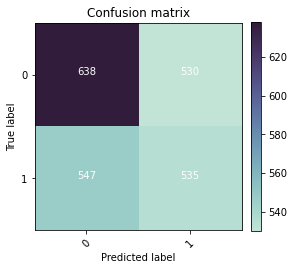

In [45]:
# Cat = 0, Dog = 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='img_path',
    y_col='label',    
    batch_size=BATCH_SIZE, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

predictions = model.predict(test_generator, verbose=1)
predictions = predictions.flatten()

results = []
for i in predictions:
    if i >= 0.5:
        results.append(1)
    else:
        results.append(0)

plt.figure(figsize=(15, 15))
for i, _img_path in enumerate(test_generator.filenames[:25]):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    if results[i] == 0:
        plt.xlabel(f'Prediction: Cat')
    else:
        plt.xlabel(f'Prediction: Dog')
    img = load_img(_img_path)
    plt.imshow(img)
    
# compute the confusion matrix
confusion_mtx = confusion_matrix(test_generator.labels, results) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(2)) 

So instead of using the above method for `prediction` on the test dataset (part of training dataset) I've used the other way where the image will flow directly from source using the `ImageDataGenerator`'s `flow` method and ImageDataGenerator won't have `y_col` (nor the `class_mode`) and `target_size`.

By doing we get results match our `evaluation` results which means that these are the right predictions that our model will make on `unseen` data.

The same process is used to make predictions of the `competitions` test dataset.

In [46]:
# Getting test data ready for prediction
test_imgs = [sample for sample in test_df.img_path]
x_test, y_test = process_images(test_imgs)
print(f'x_test length: {len(x_test)}, y_test length: {len(y_test)}')

x = np.asarray(x_test)

del x_test
gc.collect()

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(x, batch_size=BATCH_SIZE, shuffle=False)

x_test length: 2250, y_test length: 2250


141/141 [==============================] - 3s 23ms/step


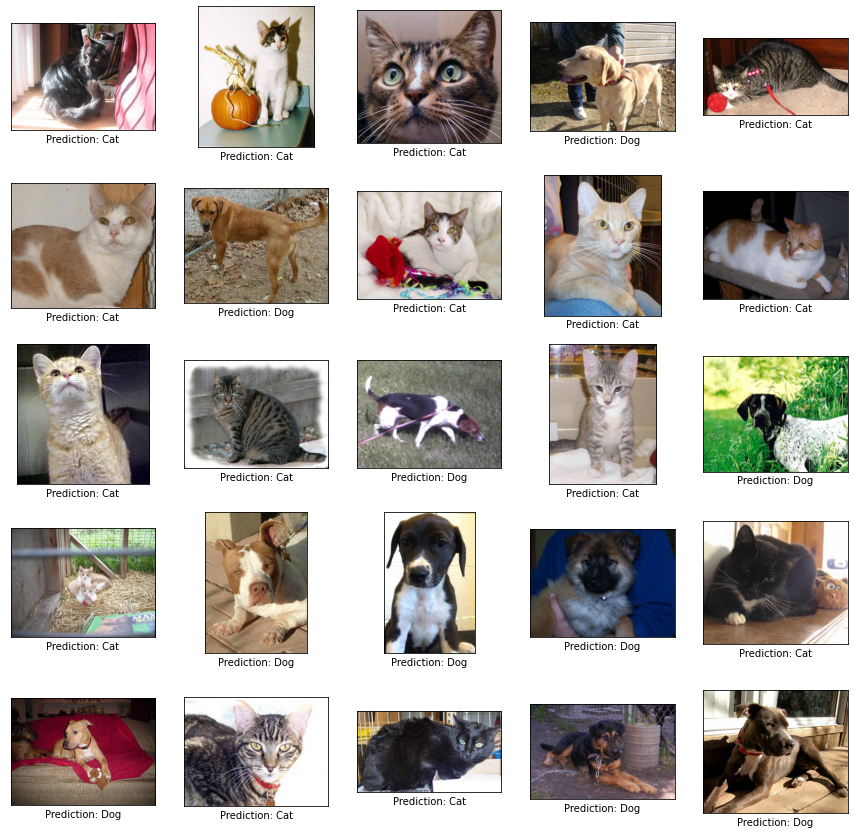

In [47]:
predictions = model.predict(test_generator, verbose=1)
predictions = predictions.flatten()

results = []
for i in predictions:
    if i >= 0.5:
        results.append(1)
    else:
        results.append(0)

plt.figure(figsize=(15, 15))
for i, _img_path in enumerate(test_imgs[:25]):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    if results[i] == 0:
        plt.xlabel(f'Prediction: Cat')
    else:
        plt.xlabel(f'Prediction: Dog')
    img = load_img(_img_path)
    plt.imshow(img)

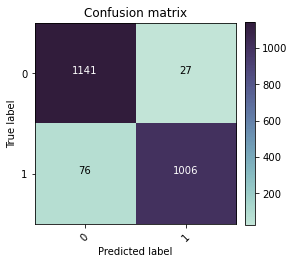

In [48]:
# compute the confusion matrix
labels_list = test_df.label.astype('int')
confusion_mtx = confusion_matrix(labels_list, results) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(2)) 

## 🔮 Predictions on test set and 📧 submitting the results

In [49]:
TEST_DIR = '../data/test/'
test_imgs = [TEST_DIR + i for i in os.listdir(TEST_DIR)]

In [50]:
# Getting test data ready for prediction
x_test, y_test = process_images(test_imgs)
print(f'x_test length: {len(x_test)}, y_test length: {len(y_test)}')

x = np.asarray(x_test)

del x_test
gc.collect()

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(x, batch_size=BATCH_SIZE, shuffle=False)

x_test length: 12500, y_test length: 0


In [51]:
predictions = model.predict(test_generator, verbose=1)
predictions = predictions.flatten()

results = []
for i in predictions:
    if i >= 0.5:
        results.append(1)
    else:
        results.append(0)

782/782 [==============================] - 18s 23ms/step


In [52]:
print(predictions[:10])
print()
print(results[:10])

[4.61894256e-09 9.96150374e-01 4.08367850e-02 1.18294526e-02
 1.42791355e-02 5.95593767e-04 9.41790998e-01 3.56681948e-03
 3.62961175e-04 1.33933267e-03]

[0, 1, 0, 0, 0, 0, 1, 0, 0, 0]


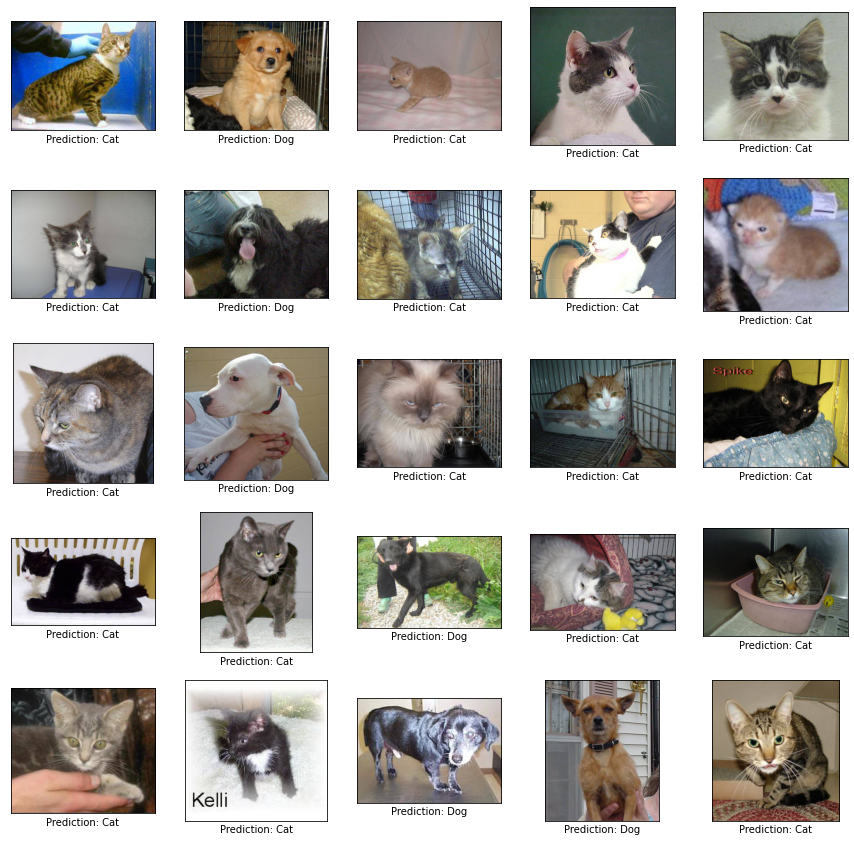

In [53]:
# Cat = 0, Dog = 1

plt.figure(figsize=(15, 15))
for i, _img_path in enumerate(test_imgs[:25]):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    if results[i] == 0:
        plt.xlabel(f'Prediction: Cat')
    else:
        plt.xlabel(f'Prediction: Dog')
    # plt.xlabel(f'Prediction: {predictions[i]}')
    img = load_img(_img_path)
    plt.imshow(img)

In [54]:
submission = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission.head()

id  label
0   1    0.5
1   2    0.5
2   3    0.5
3   4    0.5
4   5    0.5

In [55]:
for i in submission.index:
    # submission['label'].iloc[i] = results[i]
    submission['label'].iloc[i] = predictions[i]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [56]:
submission.to_csv('sample_submission.csv', index=False)
submission.head()

id         label
0   1  4.618943e-09
1   2  9.961504e-01
2   3  4.083678e-02
3   4  1.182945e-02
4   5  1.427914e-02

## **🎁 Saving the model**

In [57]:
model.save('model')

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/RETg1tippXtNm/giphy.gif)

---